In [1]:
from numpy.random import random, randint, choice
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time

In [2]:
from Sumtree import STNode, SumTree, PriorityQueue

# Priority Queues and Sum Trees

A priority queue is a queue where elements with high priority are extracted before the other elements.
A sum tree can be thought as implementing, somewhat inaccurately, a "stochastic priority queue" where elements with "higher priority" have a better probability to be extracted first.
While extracting single values might not make a difference, when sampling a significant portion of element from the structure the effect is evident - extractions are more frequent for elements with high probability.

## Why stochastic sampling with priority is useful

A __priority queue__ - such as a Fibonacci Heap - can be useful for different tasks, such as optimization and real time scheduling. On the other hand, the determinism with which the algorithm chooses the elements can be detrimental in other cases - for example, if we want to ensure that all the elements in the queue have a non-negligible possibility to be extracted.

The most relevant application in the last few years for sum trees is in __Reinforcement Learning__. In particular, a highly cited paper from 2015 (https://paperswithcode.com/paper/prioritized-experience-replay) uses a sum tree in order to reprocess training cases, by giving priority to the examples that brought the higher "surprise" to the learning agent and therefore could bring more information during training. It is important that, in sampling the best examples, there is the possibility to span over the whole example repository, in order to avoid learning only from a few subset of "good" cases. For this need, sum trees come out as an efficient solution.

## How sum trees work

Sum trees are special binary trees, where each internal node value is the sum of values of its children.
Understanding how these structures are connected to the problem of sampling numbers with different weights might not be immediate, but an intuitive explanation is the following: sum trees allow to perform a binary search over _permutated_ cumulative distribution functions, and CDFs can be used to draw weighted samples by mapping uniformly random numbers to portions of the distribution.

Well: sum trees _do not actually operate_ on CDFs, as one cannot reconstruct a CDF from the sum tree. However, the idea of how to generate a sample is similar:
- With empirical CDFs as sorted arrays, one can extract a random number $n$ in $[0,1]$ and pick the index of the value immediately greater than $n$;
- With sum trees, after extracting the random number, one goes down the tree following a simple rule according to how values are summed up, and picks the value in the final leaf node.

### How to pick up a leaf in a sum tree

For an existing sum tree, the rule to pick up a leaf value is a simple, recurrent one:
1. extract a random number in the interval $[0, root\_val]$
2. at any internal node (starting from root), check if the number to look for ($n$) is greater or smaller than the right child value.
  - if it is greater, subtract the value of the _left_ child from $n$ and proceed to the _right_ child.
  - if it is smaller, just proceed to the _left_ child
3. when at a leaf, return the object associated with that leaf. This can be just the value itself, or any other payload.

How does this work for sampling? Here is an intuitive proof of validity:
- Each node value is the sum of the values of the children, so each node is the sum of two or more leaves, and each node is a root of a smaller sum tree.
- The value of $n$ cannot be greater than $root\_val$, the value of the root.
- when moving to the right, $n$ is reduced by $l\_val$, so it is now in the range $[0, r\_val]$.
- So we will assume that we are always dealing with the root at each iteration (and we will call the search number $n$, even if the number actually can get smaller by going down the tree).
- As we are assuming that $n$ is extracted randomly from a uniform distribution, if $l\_val$ is the value of the left child and $r\_val$ is the value of the right child, we will have probability $\frac{l\_val}{root\_val}$ to go through the left branch and probability $\frac{r\_val}{root\_val}$ to go down the right branch
- repeating the process iteratively to the leaf of a tree with $l$ levels, the probability to end up in a certain leaf with value $leaf\_val$ is

$\Large\frac{leaf\_val}{node\_val_{l-1}}\times\frac{node\_val_{l-1}}{node\_val_{l-2}}\times...\times\frac{node\_val_{2}}{root\_val} = \frac{leaf\_val}{root\_val}.$

Therefore, it should be clear by now that __a sum tree allows to sample numbers or items directly proportionally to the value of each leaf__. If two leaves have the same value, they will be selected on average the same number of times.

You might see that extracting the numbers according to the underlying distribution has the same complexity of extracting an index from an empirical distribution function: since to search a sorted array we can use binary search, in both cases we can sample with a __logarithmic time complexity__. In the case of a sum tree, however, __we do not need to ensure that the values of the leaves are ordered__.

### How to insert a value in a sum tree

Depending on the implementation, it is not always the case that you actually _insert_ a new item.

For example, __in some implementations, you start with an array already full of values and simply create a sum tree "bottom-up"__, by pairing up neighboring cells. In these implementations, it is often the case that items are inserted in the array first and that the insertion triggers an update of the tree from the bottom. The update rule in this case is as simple as one can imagine: one just updates recursively all the parents with the value difference until the root. This is of course logarithmic in the number of values.

The advantages of such an implementation are:
- You do not need a downwards insertion procedure, which needs comparisons between nodes values, only to update upwards
- In case you just want to sample uniformly or pick an arbitrary value, the time complexity is $O(1)$, instead of $O(\log n)$.

Disadvantages are that 1) you need to keep the two data structures together and 2) you need to initialize a (possibly long) array in advance. In general, these implementations do not allow to retrieve data from the tree until the maximum length is reached, which might be undesiderable.

In this project, I chose a different implementation, with an explicit method to grow the tree from zero. In this implementation:
1. You do not need to create a specific array in advance or a class method to build the tree from an array. The _insert_ method is the workhorse of the structure
2. The insertion method does need to keep the tree balanced, as with any binary tree
3. You probably want to define a maximum size for the tree and, in that case, you need to think out a reasonable policy to replace the existing values once new ones arrive beyond the maximum

Ok, let's try playing a little with the structure. In the cell below, we will insert 10,000 values between 1 and 100 in an empty tree, then will extract 100,000 samples from it. We set the payload equal to the node value, so that it is easy to check whether the payloads get extracted according to the leaf values, but in general the payload can be an arbitrary object, such as a string or an entire training episode.

## A basic implementation: SumTree
The module sumtree implements a class SumTree that has two main methods: insert, retrieve and update, which is a bottom-up value update method and works as it would work for any classical sum tree implementation.

There is also a class method in order to create the tree from an existing list, _createFromList_, mutuated by @adventuresinML, but as explained it is not necessary for this kind of implementation.

The first tree we will instantiate will be quite small, so that it can be printed. The _insert_ method accepts either an existing node, or a couple of parameters:
- _val_, indicating the priority
- _payload_, the object that we want to sample fromt the tree

In order to visualize things better, in these examples the payload will be equal to the priority value.

<AxesSubplot:>

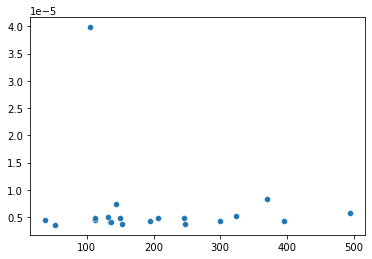

In [3]:
tree0 = SumTree()

# inserting a few values in the range [1, 500]
insert_times = []
vals = []
for i in range(20):
    val = randint(1,500)
    start_insert = time()
    tree0.insert(val=val, payload=val)
    end_insert = time()
    vals.append(val)
    insert_times.append(end_insert - start_insert)
    
sns.scatterplot(x=vals, y=insert_times)

As the scatter plot shows, it takes around 4/5 microseconds to insert a value in the tree for most insertions, with no real dependency on the size of the number.

If we try to print out the tree, it seems pretty balanced. It seems quite easy to keep a sum tree balanced: as it keeps tracks of the sums of the children, it is generally sufficient to insert new values in the branch that is currently lighter. However, there is no guarantee: for example, if we insert an unusually large number and two children become very different in value, the subtrees might become unbalanced and stay that way for a relatively long time.

In [28]:
# Binary tree pretty print util
# Credits:
# https://stackoverflow.com/a/54074933 (original thread)
# https://stackoverflow.com/users/1143396/j-v (first creator)
# https://stackoverflow.com/users/4237254/bck (revision)
# (removed some branches we are not using here)
def print_tree(root, val="val", left="left_child", right="right_child"):
    def display(root, val="val", left="left_child", right="right_child"):
        """Returns list of strings, width, height, and horizontal coordinate of the root."""
        # No child.
        if getattr(root, right) is None and getattr(root, left) is None:
            line = '%s' % getattr(root, val)
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle

        # Two children.
        left, n, p, x = display(getattr(root, left))
        right, m, q, y = display(getattr(root, right))
        s = '%s' % getattr(root, val)
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2

    lines, *_ = display(root, val, left, right)
    for line in lines:
        print(line)
        
print_tree(tree0.root)

                                         ______________________4044_____________________________                       
                                        /                                                       \                      
                       _______________1963________________               _____________________2081________________     
                      /                                   \             /                                         \    
           __________973____                         ____990_        _1113____                         __________968_  
          /                 \                       /        \      /         \                       /              \ 
     ____539____          _434____             ____496_     494    396      _717____                _598____        370
    /           \        /        \           /        \                   /        \              /        \          
  _255_       _284_     135     _299_   

### Performance

Now that we have seen a sum tree in the wild, let's try to insert a significant number of items (100,000) and see what happens if we sample from the tree.

Here below, we show how SumTree works when we insert a big array of increasing values. The expectation is that higher values will be sampled more frequently.

The insertions took 2.0802454948425293 and the sampling took 0.8196573257446289 seconds.


<AxesSubplot:ylabel='Count'>

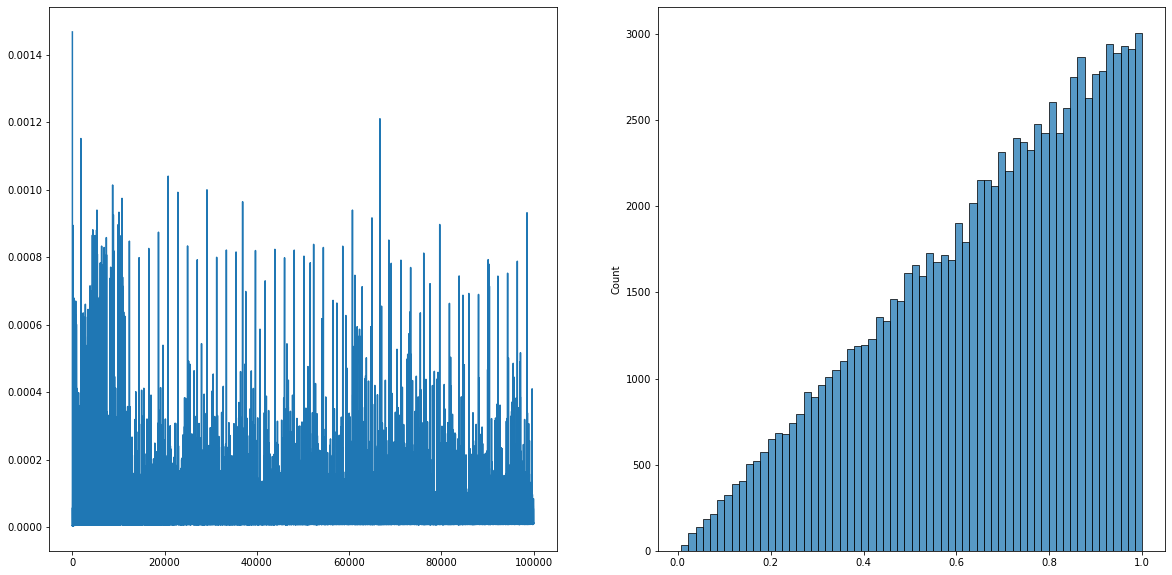

In [29]:
tree = SumTree()

# inserting 100000 values in the range [1, 100000].
# We are also measuring how long does it take for
# SumTree.insert to tackle increasingly large values.
insert_times = np.zeros(100000)
vals = []
for i in range(100000):
    val = random()
    vals.append(val)
    start_insert = time()
    tree.insert(val=val, payload=val)
    end_insert = time()
    insert_times[i] = end_insert - start_insert

indexes = []

# Sampling 100,000 values from the sumtrees.
# How long will it take?
rtval = tree.root.val
start = time()
for i in range(100000):
    random_val = random() * rtval 
    payload = tree.retrieve(random_val).payload
    indexes.append(payload)
end = time()

print(f"The insertions took {np.sum(insert_times)} and the sampling took {end-start} seconds.")

# drawing insert times and the distribution of sampled values
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=list(range(100000)), y=insert_times, ax=ax[0])
sns.histplot(sorted(indexes), ax=ax[1])

In [25]:
%timeit STNode.createLeaf(val=random(), payload=0)

1.18 µs ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Sampling 100,000 values from the tree took around 1 second, or 0.00001 seconds per sampling on average.

The two graphs above show respectively the times of each insertion and the distribution of the payloads, conveniently defined here as pure numbers (so that they can be ordered easily on the graph).

As one can see:
- Most samples are inserted in a very short time, however, periodically some insertions take much longer, and outliers of more than 1 tenth of second exist.
- With 100,000 samples the tree could follow almost perfectly the original distribution.

So, it seems that this sum tree does the job, although few insertions may be "catastrophically" slower than all the others. Since there are only three or four such outliers out of 100,000 insertions, we might ignore the problem for the moment; but we might need to investigate its causes (it might be even related to OS issues rather than to the algorithm itself).

In [31]:
large = np.where(insert_times>0.01)[0]
print(f"These values caused an outlandishly long insertion time: {[(i, vals[i]) for i in large]}")

These values caused an outlandishly long insertion time: [(44360, 0.8749484313381605), (78177, 0.3238189708211331)]


In any case, we can check and make sure that the sum tree is reasonably well balanced. We cannot do it with a tree printing utility like before, as the tree is huge, but we can verify that the maximum and the average depth and the average do not go too far from the theoretical $log_2 n$. 

In [30]:
depths = []
def sumTreeCheck(node, level):
    """Check the consistency of the nodes and gauges the depths of each leaf."""
    if node.is_leaf:
        depths.append(level)
        return
    else:
        if node.left_child is not None and node.right_child is None:
            if round(node.val, 5) != round(node.left_child.val,5):
                print(f"found node with an inconsistent sum: the parent has sum\
 {node.val} but the left child has value {node.left_child.val}")
            sumTreeCheck(node.left_child, level+1)
        elif node.right_child is not None and node.left_child is None:
            if round(node.val, 5) != round(node.right_child.val, 5):
                print(f"found node with an inconsistent sum: the parent has sum\
 {node.val} but the left child has value {node.right_child.val}")
            sumTreeCheck(node.right_child, level+1)
        elif node.right_child is not None and node.left_child is not None:
            if round(node.val, 5) != round(node.right_child.val + node.left_child.val, 5):
                print(f"found node with an inconsistent sum: the parent has sum\
 {node.val} but the children have value {node.left_child.val} and {node.right_child.val}")
            sumTreeCheck(node.right_child, level+1)
            sumTreeCheck(node.left_child, level+1)

sumTreeCheck(tree.root, 0)
print(f"The maximum depth of the tree is {max(depths)} and the average depth is \
{np.mean(depths)} (standard deviation {np.std(depths)}),\n\
while the logarithm of the number of leaves ({len(depths)}) is {np.log2(len(depths))}")

The maximum depth of the tree is 20 and the average depth is 16.77384 (standard deviation 0.7232507548561563),
while the logarithm of the number of leaves (100000) is 16.609640474436812


# PriorityQueue, a sofisticated SumTree

So far, (almost) so good. In order to use a sum tree properly for Prioritized Experience Replay (PER), we might need some more pieces.
- Define a maximum size for the tree, and a policy for replacing leaves
- Modulate the sampling policy (e.g. importance sampling) - more on that later
- Update existing leaves (implemented in Sum Tree but unused)

We will go through the three points above in more detail now.
PriorityQueue also includes a new method, _sample_, which accepts a _sample_size_ parameter. 

## Replacing leaves

If we are to keep a maximum number of payloads, it is essential that we choose a policy to replace old values. Conceivable policies could be:
1. to replace items randomly
2. to replace items with the biggest values
3. to replace items with a similar value

Thinking of how experience replay should work, there are other suitable candidates:

4. replacing the older items
5. replacing only the items that have been replayed (and that have been sampled previously according to the sum tree)

The current implementation supports numbers 3 and 4. Replacing values with a similar values is done by default with the _insert_ method after the maximum capacity has been reached. Method number 5, which is extensively used for PER, can be used with the _update_ method applied to the nodes that have been extracted during the training.

## Importance sampling

According to Schaul et al. (https://arxiv.org/abs/1511.05952),
>The estimation of the expected value with stochastic updates relies on those updates corresponding
to the same distribution as its expectation. Prioritized replay introduces bias because it changes this
distribution in an uncontrolled fashion, and therefore changes the solution that the estimates will
converge to (even if the policy and state distribution are fixed).

For this reason, they introduced a modulating factor to the values used in the sum tree, which basically levels out the priorities at the high end of the distribution.

$w_{i} = \left(\frac{1}{N}\cdot\frac{1}{P\left(i\right)}\right)^{\beta}$, where $P\left(i\right) = \frac{p_{j}^{\alpha}}{\sum_{i}{p_{i}^{\alpha}}}$

The factor $w_{i}$ is then multiplied by the original priority before it is stored in the tree.

This is a difference with the original application of IS described in Schaul, where it seems that the weighting is applied only during the parameter update, but since this is a monotone transformation that basically only "dampens" the effect of the sum tree to the highest priority payloads, and that the original motivation for applying importance sampling is to contain the effect of a linear prioritization according to value, it should not be a problem, and it simplifies the process.


## Performance

As one can see below, the performance of this more sophisticated version is slightly higher than original SumTree, as the importance sampling step does take some millisecond more, but in the context of RL, where the insertion happens at the end of an agent play, it does not represent a significant difference.

A sample of 100000 was generated in 1.802398920059204 seconds.


<AxesSubplot:ylabel='Count'>

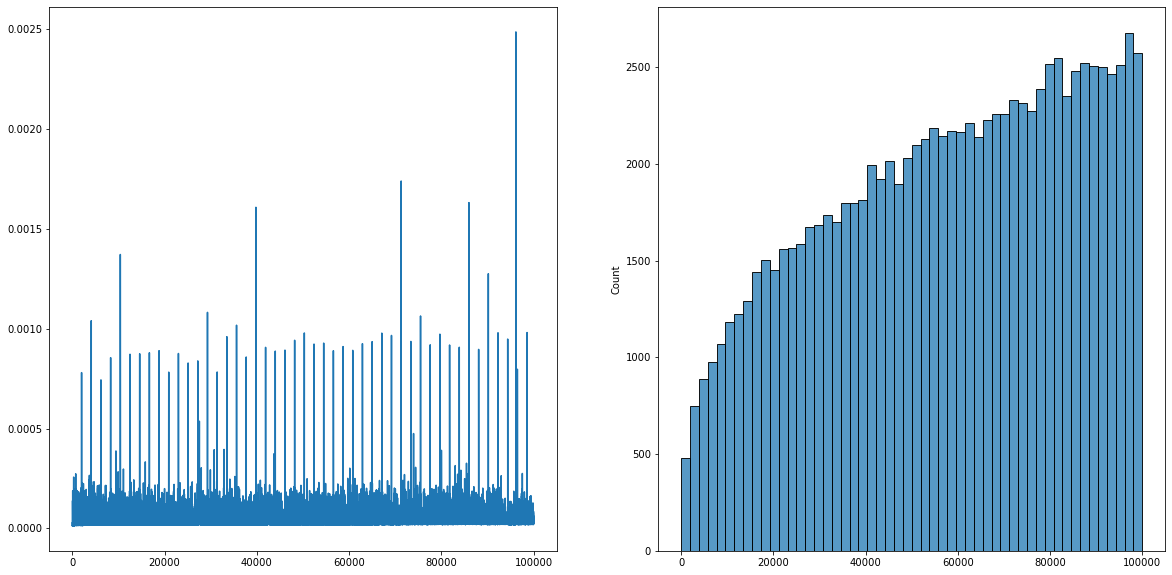

In [44]:
max_size = 100000
start = time()
prior = PriorityQueue(max_size=max_size)

insert_times_p = np.zeros(100000)
for i in range(100000):
    val = randint(1, 100000)
    start_insert = time()
    prior.insert(val=val, payload=val)
    end_insert = time()
    insert_times_p[i] = end_insert - start_insert

sample_start = time()
total = prior.root.val
sample = prior.sample(max_size)
sample_end = time()

print(f"A sample of {max_size} was generated in {sample_end - sample_start} seconds.")

# drawing insert times and the distribution of sampled values
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=list(range(100000)), y=insert_times_p, ax=ax[0])
sns.histplot(sorted(sample), ax=ax[1])

Also, we expect the insertion of $n$ items to have complexity proportional to $n*log(n)$. This is also verified, as one can see below.

In [45]:
insert_times = []
sample_times = []

for size in range(10000, 100001, 2000):
    print(f"testing size {size}...")
    prior2 = PriorityQueue(max_size=size)
    insert_start = time()
    for i in range(size):
        val = randint(1, size)
        prior2.insert(val=val, payload=val)
    insert_end = time()
    total = prior2.root.val
    sample = prior2.sample(size)
    sample_end = time()
    insert_times.append(insert_end - insert_start)
    sample_times.append(sample_end - insert_end)

testing size 10000...
testing size 12000...
testing size 14000...
testing size 16000...
testing size 18000...
testing size 20000...
testing size 22000...
testing size 24000...
testing size 26000...
testing size 28000...
testing size 30000...
testing size 32000...
testing size 34000...
testing size 36000...
testing size 38000...
testing size 40000...
testing size 42000...
testing size 44000...
testing size 46000...
testing size 48000...
testing size 50000...
testing size 52000...
testing size 54000...
testing size 56000...
testing size 58000...
testing size 60000...
testing size 62000...
testing size 64000...
testing size 66000...
testing size 68000...
testing size 70000...
testing size 72000...
testing size 74000...
testing size 76000...
testing size 78000...
testing size 80000...
testing size 82000...
testing size 84000...
testing size 86000...
testing size 88000...
testing size 90000...
testing size 92000...
testing size 94000...
testing size 96000...
testing size 98000...
testing si

/home/liapunov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/liapunov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/home/liapunov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/liapunov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


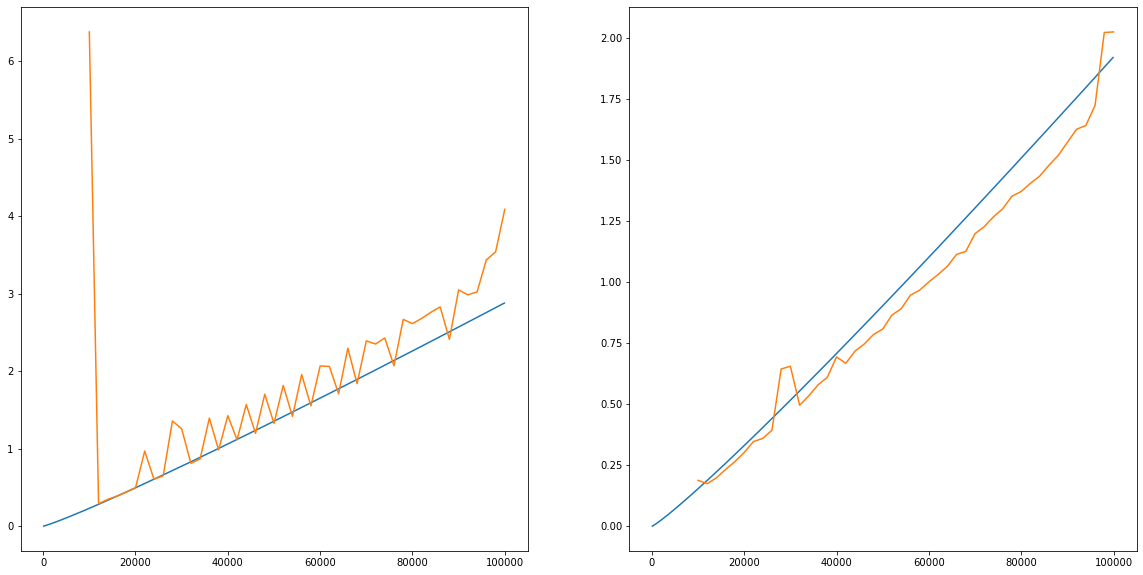

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
logline_x = np.linspace(0, 100000, 1000)
insert_logline = logline_x * np.log(logline_x) * (1/400000)
sns.lineplot(x=list(range(0, 100000, 100)), y=insert_logline, ax=ax[0])
sns.lineplot(x=list(range(10000, 100001, 2000)), y=insert_times, ax=ax[0])
sample_logline = logline_x * np.log(logline_x) * (1/600000)
sns.lineplot(x=list(range(0, 100000, 100)), y=sample_logline, ax=ax[1])
sns.lineplot(x=list(range(10000, 100001, 2000)), y=sample_times, ax=ax[1])
plt.show()

## Conclusion and next steps

This notebook has focused on a useful data structure for Reinforcement Learning that not many talk about in some depth. Sum trees make for excellent priority buffers, but the implementation might not be straightforward (especially in the insertion phase) and many choices exist. In any case, the common feature is a logarithmic complexity in both insertion and extraction, which justifies its use compared to normal arrays or other samplers.

The next update for this project would be to have this structure utilised in a RL method in a openai-gym environment.
Stay tuned.

## Appendix 1 - Can probability distributions be reconstructed by a Sum Tree?

In [8]:
def ecdfFromDistro(distro):
    distro.insert(0, 0)
    for i in range(1, len(distro)):
        distro[i] = distro[i] + distro[i-1]
    return distro[1:]

def ecdfFromTree(tree):
    root = tree.root
    total = root.val
    distro = [0]
    def traverseAppend(node):
        if node.is_leaf:
            distro.append(node.val/total)
        else:
            traverseAppend(node.left_child)
            traverseAppend(node.right_child)
    traverseAppend(root)
    ecdf = ecdfFromDistro(distro)
    return ecdf

def drawECDF(tree):
    ecdf = ecdfFromTree(tree)
    x = list(range(len(ecdf)))
    sns.lineplot(x=x, y=ecdf, drawstyle='steps-pre')
    plt.show()

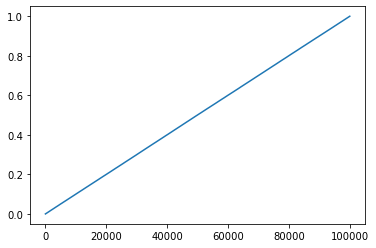

In [9]:
drawECDF(prior)

In [21]:
from scipy.stats import norm
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100000)
y = norm.pdf(x)

<AxesSubplot:>

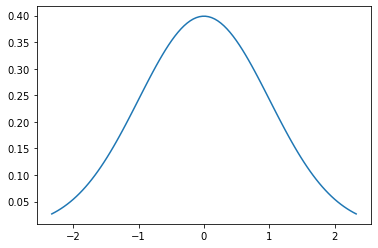

In [12]:
sns.lineplot(x=x, y=y)

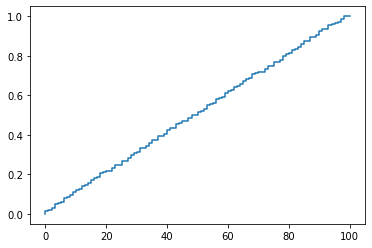

In [14]:
tree_norm = SumTree()
for i in range(100):
    tree_norm.insert(val=y[i], payload=i)
    
drawECDF(tree_norm)

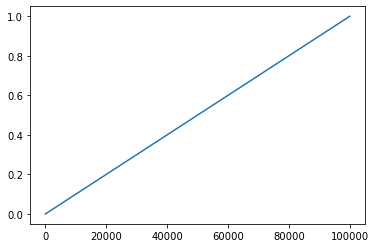

In [22]:
prior_norm = PriorityQueue(max_size=100000)
for i in range(100000):
    prior_norm.insert(val=y[i], payload=i)
    
drawECDF(prior_norm)

<AxesSubplot:ylabel='Count'>

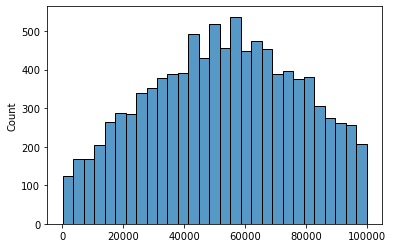

In [23]:
sample_norm = prior_norm.sample(10000)
sns.histplot(sample_norm)

In [24]:
prior2 = PriorityQueue(max_size=max_size)
%timeit randint(1, max_size)

2.37 µs ± 62.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
print(insert_times)
print(sample_times)